# Исследование оттока клиентов фитнес-центра

## Общие положения

**Заказчик** — отдел по работе с клиентами, отдел маркетинга

**Цель исследования** - провести анализ данных по клиентам и подготовить план действий по их удержанию

**Исходные данные** — данные из анкет клиентов с фактом оттока

**Вопросы, которые интересуют заказчика:**

1. Прогноз вероятности оттока
2. Типичные портреты клиентов
3. Какие признаки оказывают наибольшее влияние на отток?
4. Какие целевые группы клиентов, на которых стоит сфокусировать действия по удержанию?
5. Какие меры могут снизить отток?

**Основные шаги:**

- Загрузка данных
- Исследовательский анализ и предобработка данных
- Построение модели прогнозирования оттока клиентов
- Проведение кластеризации клиентов
- Формулировка выводов и рекомендация

### Описание данных
«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
- 'Churn' — факт оттока в текущем месяце;
- Текущие поля в датасете:
    - Данные клиента за предыдущий до проверки факта оттока месяц:
        - 'gender' — пол;
        - Near_Location' — проживание или работа в районе, где находится фитнес-центр;
            -'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
        - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
        - 'Phone' — наличие контактного телефона;
        - 'Age' — возраст;
        - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
       
    - Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
        - 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
        - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
        - 'Group_visits' — факт посещения групповых занятий;
        - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
        - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
        - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.
        
Путь к файлу: /datasets/gym_churn.csv


## Загрузка данных

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
#чтение файла
try:
    df = pd.read_csv('/datasets/gym_churn.csv', sep=',')
except:
    path = 'C:/Users/au31894/OneDrive - Alliance/Рабочий стол/Программирование/Исходные данные/'
    df = pd.read_csv(path + 'gym_churn.csv')

display(df.head())
display(df.info())    

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


None

## Исследовательский анализ и предобработка данных

#### Комментарий
- Пропусков в данных не обнаружено
- Есть категориальные переменные: пол, Contract_period. 
- Есть логические переменные: Near_Location, Partner, Promo_friends, Phone, Group_visits, Churn

Данные переменные представлены числовыми значениями, это может создать сложности при использовании моделей линейной регрессии, но задача оттока клиентов (бинарная классификация) и их кластеризации к таким моделям отношения не имеют.

In [3]:
# проверка на дубликаты
print('Дубликаты в базе объектов:', df.duplicated().sum())

Дубликаты в базе объектов: 0


#### Комментарий
Полных дубликатов не обнаружено

In [4]:
#просмотр уникальных значений
def unique_function(data):
    for col in data:
        print('Уникальные значения:', col)
        display(data[col].value_counts())

unique_function(df)

Уникальные значения: gender


1    2041
0    1959
Name: gender, dtype: int64

Уникальные значения: Near_Location


1    3381
0     619
Name: Near_Location, dtype: int64

Уникальные значения: Partner


0    2053
1    1947
Name: Partner, dtype: int64

Уникальные значения: Promo_friends


0    2766
1    1234
Name: Promo_friends, dtype: int64

Уникальные значения: Phone


1    3614
0     386
Name: Phone, dtype: int64

Уникальные значения: Contract_period


1     2207
12     960
6      833
Name: Contract_period, dtype: int64

Уникальные значения: Group_visits


0    2351
1    1649
Name: Group_visits, dtype: int64

Уникальные значения: Age


29    468
30    457
28    447
31    434
27    378
32    364
26    300
33    253
25    231
34    174
24    148
35     98
23     82
36     48
22     33
37     29
21     24
20     14
38     10
39      3
19      2
18      2
41      1
Name: Age, dtype: int64

Уникальные значения: Avg_additional_charges_total


135.756722    1
97.623617     1
82.487277     1
17.911351     1
74.882931     1
             ..
163.080276    1
133.640108    1
9.838696      1
134.699410    1
357.046942    1
Name: Avg_additional_charges_total, Length: 4000, dtype: int64

Уникальные значения: Month_to_end_contract


1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       25
3.0       23
2.0       14
Name: Month_to_end_contract, dtype: int64

Уникальные значения: Lifetime


1     843
2     610
3     490
0     487
4     383
5     273
6     220
7     167
8     111
9     100
10     76
12     53
11     48
13     28
14     24
15     24
16     15
17     11
19      7
20      7
18      7
21      5
24      2
22      2
26      2
23      2
29      1
27      1
31      1
Name: Lifetime, dtype: int64

Уникальные значения: Avg_class_frequency_total


0.000000    88
3.071431     1
3.275314     1
2.687575     1
0.751450     1
            ..
1.801802     1
3.519139     1
1.750208     1
1.315297     1
2.863927     1
Name: Avg_class_frequency_total, Length: 3913, dtype: int64

Уникальные значения: Avg_class_frequency_current_month


0.000000    181
2.038709      1
1.202066      1
2.981590      1
2.618891      1
           ... 
1.287944      1
2.349070      1
3.399411      1
0.472735      1
3.720636      1
Name: Avg_class_frequency_current_month, Length: 3820, dtype: int64

Уникальные значения: Churn


0    2939
1    1061
Name: Churn, dtype: int64

#### Комментарий
При беглом анализе видно, что:
- в выборке примерно равное распределение полов
- среди клиентов преобладают те, кто живет рядом
- примерно половина клиентов - сотрудники компаний-партнеров
- преобладают клиенты, которые приходят сами, без использования промокода от друзей, знакомых
- большинство клиентов указали свой телефон
- большинство абонементов - месячные
- больше половины клиентов посещают групповые занятия
- возраст клиентов от 18 до 41 года
- примерно четверть клиентов из выборки перестала пользоваться услугами в текущем месяце

In [5]:
# изучим средние и стандартные отклонения
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


#### Комментарий
- В категориальных (пол) и логических переменных(Near_Location, Partner, Promo_friends, Phone, Group_visits, Churn) выборки признаки принимают значения 1 или 0 и сильных выбросов там не может быть
- По возрасту,кол-во месяцев до конца контракта, время с первого обращения также нет серьезных выбросов и значения там вполне предсказуемы
- Выручка за доп.услуги, средняя частота посещений в неделю, средняя частота посещений в месяц также близки к медиане - серьезные выбросы на первый взгляд отсутствуют

In [6]:
# группируем данные по признаку оттока и подсчитываем средние
df_grouped = df.groupby('Churn').mean()
display(df_grouped)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


#### Комментарий
При сравнении средних признаков между выбывшими и не выбывшим клиентами видно, что:
- Пол, наличие телефона, возраст практически не влияет на отток (по первым двум признакам 0,51 и 0,9 соответственно у обеих групп, пол - 27 - 30 лет - мало отличается)
- Влияют на отток: 
    - удаленность от фитнес-центра (0,35 у выбывших vs 0,53 у не выбывших), 
    - посещение по партнерской программе (0,18 vs 0,35), 
    - период действия абонемента (1,7 мес vs 5,7 мес), 
    - посещение групповых программ (0,26 vs 0,46), 
    - доп.услуги (115 vs 158), 
    - месяцы до окончания абонемента (1,7 vs 5,3)
    - время с момента первого посещения (1 vs 4,7 мес)
    - среднее кол-во посещений в неделю (1,47 vs 2)
    - среднее кол-во посещений в месяц (1 vs 2)

GENDER


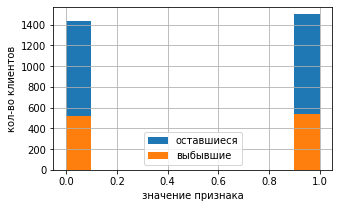

NEAR_LOCATION


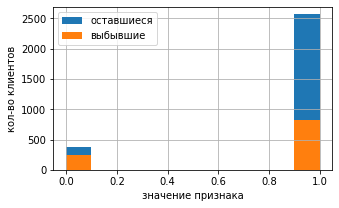

PARTNER


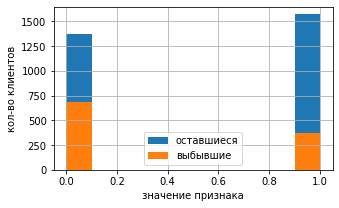

PROMO_FRIENDS


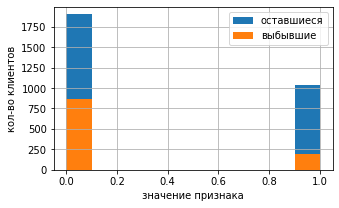

PHONE


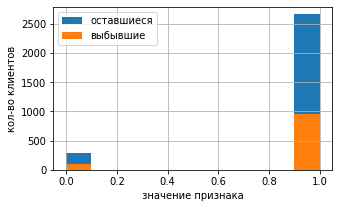

CONTRACT_PERIOD


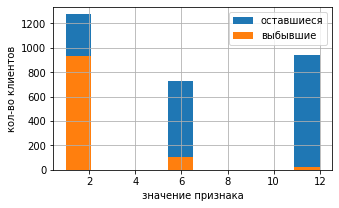

GROUP_VISITS


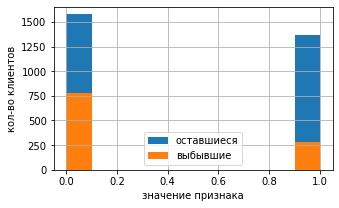

AGE


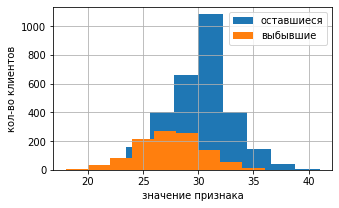

AVG_ADDITIONAL_CHARGES_TOTAL


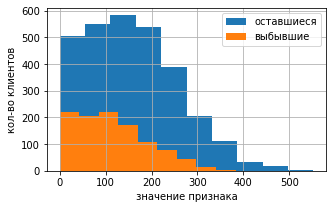

MONTH_TO_END_CONTRACT


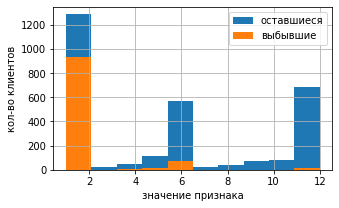

LIFETIME


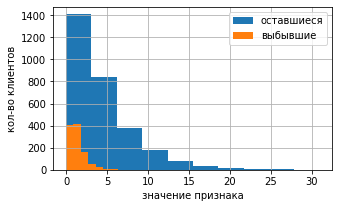

AVG_CLASS_FREQUENCY_TOTAL


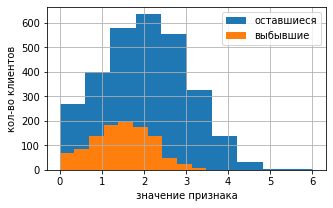

AVG_CLASS_FREQUENCY_CURRENT_MONTH


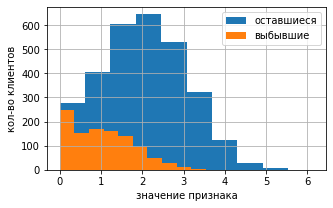

CHURN


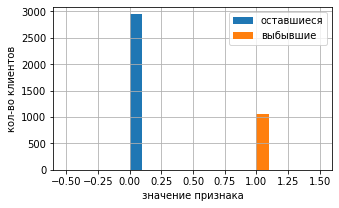

In [7]:
# пишем функцию построения гистограмм по колонкам
for column in df.columns:
        print(column.upper())
        fig = plt.figure(figsize=(5,3))
        df.query('Churn == 0')[column].hist(bins=10, label='оставшиеся')
        df.query('Churn == 1')[column].hist(bins=10, label='выбывшие')
        plt.ylabel('кол-во клиентов')
        plt.xlabel('значение признака')
        plt.legend()
        plt.show()

#### Комментарий
На основе частотных гистограмм видно, что среди выбывших:
-  больше клиентов живут не в районе фитнес-центра
-  больше клиентов не являются сотрудниками компаний-партнеров
-  меньше клиентов пришли по промокоду друзей
-  большинство клиентов покупают месячные абонементы
-  меньше клиентов посещают групповые занятия
-  у большинства клиентов до окончания остался месяц
-  большинство клиентов посещают центр 0-1 месяц с первого посещения
-  диапазон среднего кол-ва посещений в неделю от 0 до 3.5 - меньше, чем у не выбывших (от 0 до 6)
-  относительное большинство клиентов не посещает центр в последний месяц (0 посещений в неделю за текущий месяц)

Распределение возрастов похоже на нормальное. 
Среди и выбывших и не выбывших клиентов много тех, кто не посещает центр. 

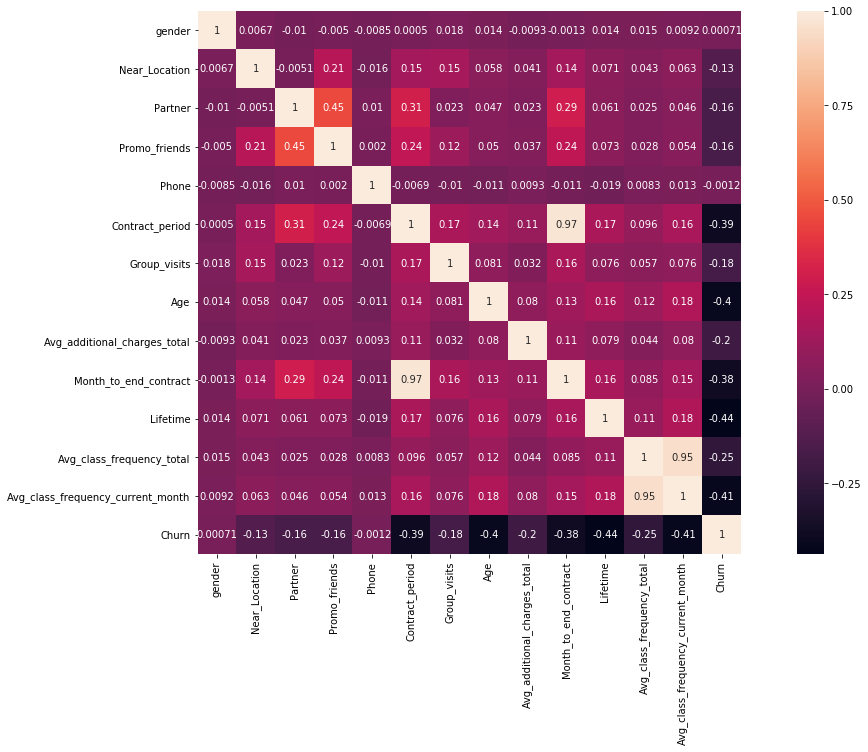

In [8]:
# cстроим матрицу корреляций и наносим на heatmap
cm = df.corr()
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(cm, annot = True, square=True) #ваш код здесь
plt.show()

#### Комментарий
Наблюдается сильная корреляция между признаками:
- Кол-во месяцев до окончания абонемента и срок действия абонемента - чем больше срок, тем больше будет наблюдений с бОльшим сроком до окончания
- Среднее кол-во посещений в неделю и среднее кол-во посещений за неделю в текущий месяц - скорее все те, у кого уже сформировался график посещений будут ходить в текущий месяц с той же частотой

Это может влиять на линейные алгоритмы (мультиколлинеарность), в частности на логистическую регрессию, поэтому для ее корректной работы удалить по одному из каждой пары этих признаков. 

In [9]:
# удаляем по одному из сильно коррелирующих признаков
df_for_model = df.drop(['Avg_class_frequency_total', 'Month_to_end_contract'], axis = 1)
display(df_for_model.head())
display(df.head())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,3,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,7,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,2,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.120078,0


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


### Вывод
- В ходе анализа признаков выявлены бинарные (gender, Near_Location, Partner, Promo_friends, Phone, Group_visits, Churn) и небинарные
- Дубликаты и пропуски не обнаружены
- Среди выбывших клиентов:
    -  больше клиентов живут не в районе фитнес-центра
    -  больше клиентов не являются сотрудниками компаний-партнеров
    -  меньше клиентов пришли по промокоду друзей
    -  большинство клиентов покупают месячные абонементы
    -  меньше клиентов посещают групповые занятия
    -  у большинства клиентов до окончания остался месяц
    -  большинство клиентов посещают центр 0-1 месяц с первого посещения
    -  диапазон среднего кол-ва посещений в неделю от 0 до 3.5 - меньше, чем у не выбывших (от 0 до 6)
    -  относительное большинство клиентов не посещает центр в последний месяц (0 посещений в неделю за текущий месяц)
- Есть сильная корреляци:
    -  Кол-вом месяцев до окончания абонемента и срок действия абонемента
    -  Среднее кол-во посещений в неделю и среднее кол-во посещений за неделю в текущий месяц 

## Модель прогнозирования оттока клиентов

In [10]:
# разделение датафрейма на целевую переменную и обучающие признаки
y = df_for_model['Churn']
X = df_for_model.drop(['Churn'], axis = 1)
# разделяем выборку на обучающую и валидационную
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
# формируем список моделей классификации
models = [
    LogisticRegression(solver='liblinear', random_state=0),
    DecisionTreeClassifier(random_state=0),
]

In [12]:
# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'accuracy:{:.2f} precision:{:.2f} recall:{:.2f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
        )
    )
    return y_pred

In [13]:
# цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(i, X_train, y_train, X_test, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
accuracy:0.90 precision:0.79 recall:0.79
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')
accuracy:0.86 precision:0.69 recall:0.77


### Вывод
На основе сравнения параметров лучшей моделью оказалась - логистическая регрессия

## Кластеризация

In [14]:
# Стандартизация данных
scaler = StandardScaler()
# стандартизируем признаки
df_sc = df.drop(['Churn'], axis = 1)
df_sc[['Age','Lifetime', 'Contract_period', 'Month_to_end_contract', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month', 'Avg_additional_charges_total']] = scaler.fit_transform(df_sc[['Age','Lifetime', 'Contract_period', 'Month_to_end_contract', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month', 'Avg_additional_charges_total']])
x_sc = df_sc
x_sc.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,1,1,1,1,0,0.289890,1,-0.056554,-1.377531,0.161605,-0.193329,-1.911920,-1.678472
1,0,1,0,0,1,1.608822,1,0.557327,-0.350213,1.831941,0.873680,0.045176,0.136014
2,0,1,1,0,1,-0.809219,0,-0.363494,-0.181592,-0.792873,-0.460081,-0.020493,-0.029019
3,0,1,1,1,1,1.608822,1,1.171208,-0.874722,1.831941,-0.460081,1.364655,1.510450
4,1,1,1,1,1,-0.809219,0,-0.977375,0.533700,-0.792873,-0.193329,-0.787076,-0.614542


In [15]:
# сохраняем таблицу связок между объектами
linked = linkage(x_sc, method = 'ward')

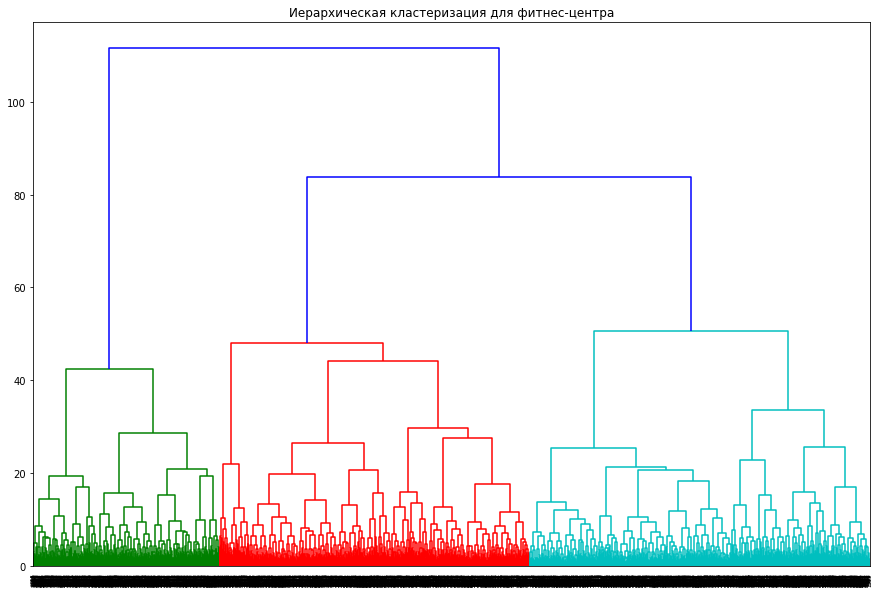

In [16]:
# рисуем дендрограмму
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для фитнес-центра')
plt.show()

#### Комментарий
На основе дендрограммы можно выделить 3 кластера на основе цветов, также можно выбрать третий уровень - 5 кластеров, выбираем 5 по договоренности.

In [17]:
# обучаем модель KMeans
km = KMeans(n_clusters = 5, random_state=0) # задаём число кластеров, равное 5
labels = km.fit_predict(x_sc) # применяем алгоритм к данным и формируем вектор кластеров

In [18]:
# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

# группируем клиентов по кластерам, признаку оттока и средним значениям
df_grouped2 = df.groupby(['cluster_km', 'Churn']).mean()
df_grouped2 = df_grouped2.reset_index()
display(df_grouped2)

,cluster_km,Churn,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,0,0,0.524752,0.909241,0.673267,0.448845,0.896040,9.415842,0.506601,30.095710,167.320409,8.706271,3.676568,0.992248,0.995506
1,0,1,0.653061,0.897959,0.693878,0.387755,0.918367,7.836735,0.346939,27.653061,150.253404,7.428571,1.061224,1.048067,0.582747
2,1,0,0.525708,0.848898,0.430220,0.295908,0.907660,2.748164,0.423924,30.272823,160.238659,2.627492,3.720881,2.815228,2.823357
3,1,1,0.504425,0.796460,0.327434,0.185841,0.902655,1.840708,0.300885,28.230088,129.325090,1.796460,0.946903,2.532596,2.345228
4,2,0,0.527027,0.871622,0.452703,0.297297,0.861486,3.550676,0.459459,29.976351,148.608957,3.222973,12.635135,1.856308,1.864625
5,2,1,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,33.000000,208.071672,1.000000,8.000000,1.974417,1.518766
6,3,0,0.480695,0.810811,0.401544,0.231660,0.915058,1.395753,0.401544,29.318533,145.247090,1.305019,3.270270,1.164328,1.158573
7,3,1,0.502247,0.757303,0.337079,0.171910,0.902247,1.286517,0.259551,26.800000,111.377315,1.248315,0.983146,1.355323,0.896975
8,4,0,0.485866,0.932862,0.724382,0.489399,0.916961,12.000000,0.545936,29.952297,163.148591,10.807420,4.664311,2.675451,2.674803
9,4,1,0.625000,0.750000,0.750000,0.250000,0.875000,12.000000,0.250000,25.750000,99.115188,10.625000,1.125000,2.402377,1.858820


#### Комментарий
- Почти во всех кластерах (кроме 1) в среднем больше представителей пола 1
- Почти во всех кластерах, кроме 2 (но там всего 1 выбывший, так что не показательно) среди выбывших больше тех, кто живет не в районе центра
- Во всех кластерах среди выбывших преобладают те, кто пришел сам, а не по промокоду
- Почти во всех кластерах (кроме 4) длительность абонемента у выбывших ниже
- Почти во всех кластерах, кроме 2 (но там всего 1 выбывший, так что не показательно) среди выбывших больше тех, кто не посещал групповые занятия
- Почти во всех кластерах, кроме 2 (но там всего 1 выбывший, так что не показательно) выбывшие чуть моложе, чем оставшиеся
- Во всех кластерах у выбывших до конца абонемента остается меньше месяцев
- Во всех кластерах lifetime у выбывших меньше, чем у оставшихся
- Почти во всех кластерах, кроме 2 (но там всего 1 выбывший, так что не показательно) выбывшие тратят на доп.услуги меньше, чем оставшиеся
- Во всех кластерах у выбывших падает частота посещений в неделю в текущем месяце

In [19]:
def hist_maker(df, query_pam1):
    for column in df.columns:
        print(column.upper())
        fig = plt.figure(figsize=(5,3))
        df.query(query_pam1)[column].hist(bins=15)
        #df.query('Churn == 1')[column].hist(bins=10, label='выбывшие')
        plt.ylabel('кол-во клиентов')
        plt.xlabel('значение признака')
        plt.show()

### Кластер 0

GENDER


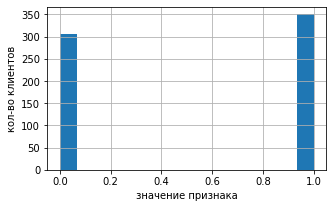

NEAR_LOCATION


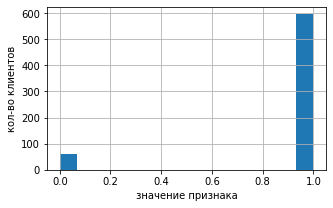

PARTNER


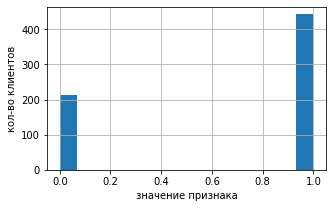

PROMO_FRIENDS


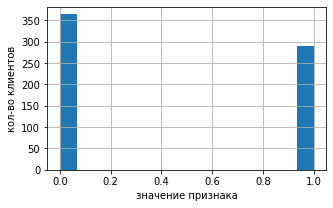

PHONE


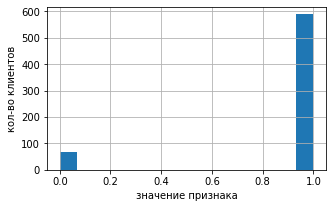

CONTRACT_PERIOD


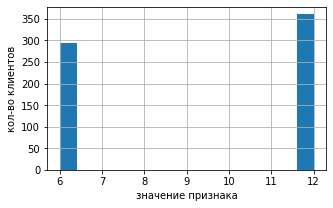

GROUP_VISITS


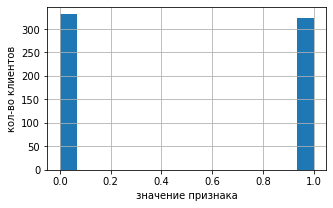

AGE


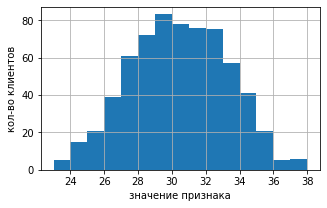

AVG_ADDITIONAL_CHARGES_TOTAL


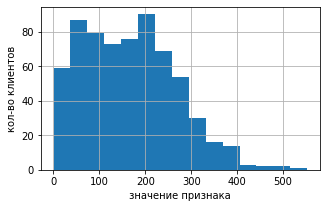

MONTH_TO_END_CONTRACT


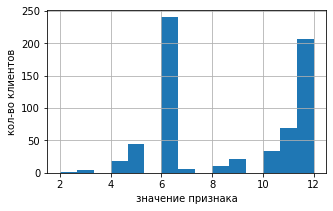

LIFETIME


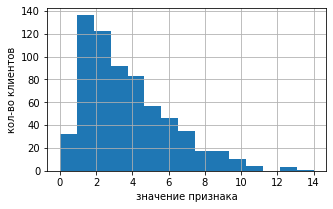

AVG_CLASS_FREQUENCY_TOTAL


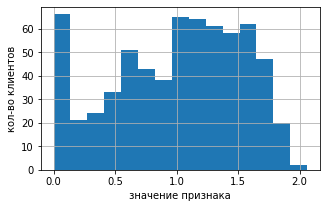

AVG_CLASS_FREQUENCY_CURRENT_MONTH


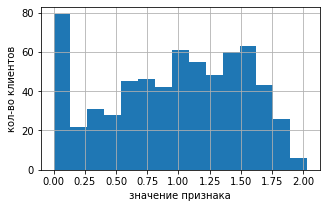

CHURN


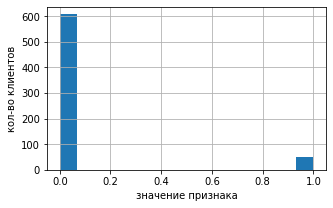

CLUSTER_KM


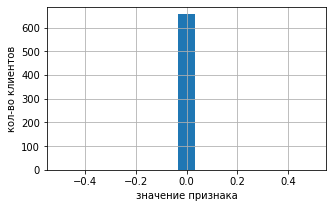

,cluster_km,Churn,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,0,0,0.524752,0.909241,0.673267,0.448845,0.896040,9.415842,0.506601,30.095710,167.320409,8.706271,3.676568,0.992248,0.995506
1,0,1,0.653061,0.897959,0.693878,0.387755,0.918367,7.836735,0.346939,27.653061,150.253404,7.428571,1.061224,1.048067,0.582747


In [20]:
# строим гистограммы распределения для кластера 0
hist_maker(df, 'cluster_km == 0')
df_grouped2_0 = df_grouped2.query('cluster_km == 0')
display(df_grouped2_0)

#### Комментарий кластер 0
- распределение по полам различается некритично
- клиент в большинстве случаев живет в районе фитнес-центра
- **скорее сотрудник, чем обычный клиент**
- **скорее приходит без промокода, но различия незначительные**
- указывает номер телефона
- **берет абонемент на 6 или 12 мес.**
- может посещать или не посещать групповые занятия, различия минимальны
- возраст около 26-34 года
- доп.траты у большинства клиентов до 250 у.е.
- **до окончания контракта в большинстве случаев осталось 6 или 12 мес.**
- может быть как новым, так и старым клиентом, но большинство в диапазоне от 1 до 7 мес. от первого посещения
- **менее 2 месяцев, высокая доля тех, кто не ходит** 
- **менее 2 месяцев, высокая доля тех, кто не ходит в неделю в текущем месяце, высокая доля тех, кто не ходит**

### Кластер 1

GENDER


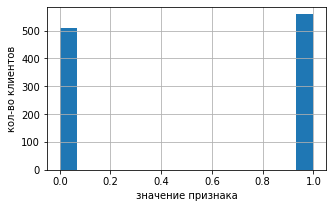

NEAR_LOCATION


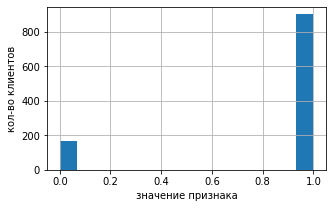

PARTNER


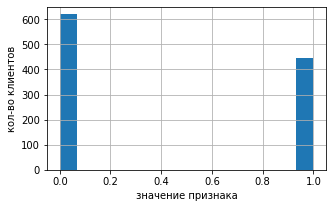

PROMO_FRIENDS


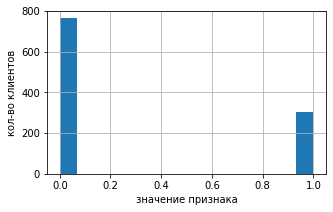

PHONE


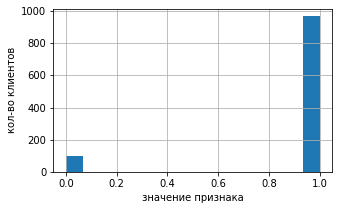

CONTRACT_PERIOD


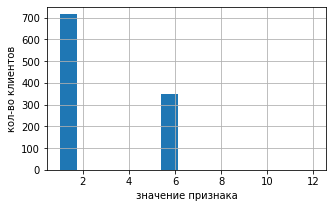

GROUP_VISITS


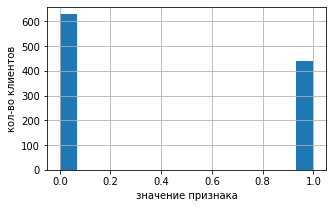

AGE


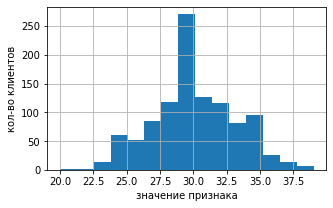

AVG_ADDITIONAL_CHARGES_TOTAL


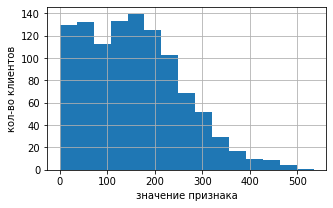

MONTH_TO_END_CONTRACT


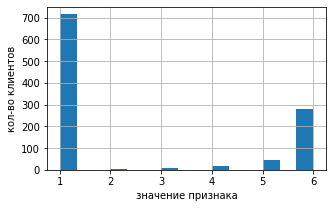

LIFETIME


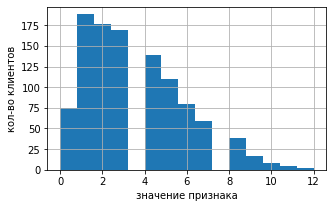

AVG_CLASS_FREQUENCY_TOTAL


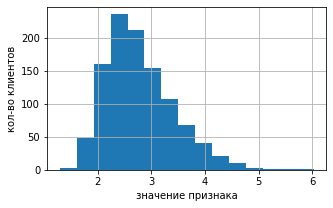

AVG_CLASS_FREQUENCY_CURRENT_MONTH


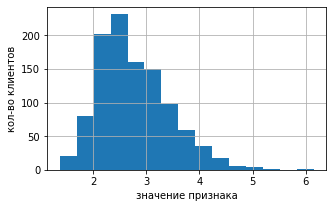

CHURN


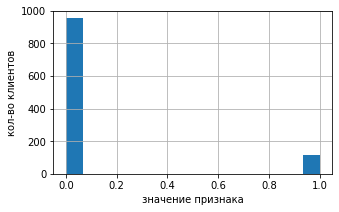

CLUSTER_KM


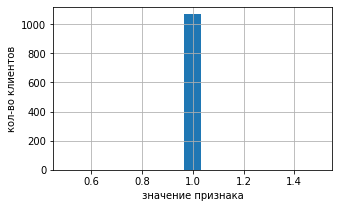

,cluster_km,Churn,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
2,1,0,0.525708,0.848898,0.430220,0.295908,0.907660,2.748164,0.423924,30.272823,160.238659,2.627492,3.720881,2.815228,2.823357
3,1,1,0.504425,0.796460,0.327434,0.185841,0.902655,1.840708,0.300885,28.230088,129.325090,1.796460,0.946903,2.532596,2.345228


In [21]:
# строим гистограммы распределения для кластера 1
hist_maker(df, 'cluster_km == 1')
df_grouped2_1 = df_grouped2.query('cluster_km == 1')
display(df_grouped2_1)

#### Комментарий кластер 1
- распределение по полам отличается некритично
- клиент в большинстве случаев живет в районе фитнес-центра
- может быть как сотрудником компании-партнера, так и обычным клиентом, различия минимальны
- в большинстве случаев приходит без использования промо-кода друзей
- указывает номер телефона
- **в большинстве случаев берет абонемент на 1 или 6 мес**
- может как посещать, так и не посещать групповые занятия, различия некритичны
- возраст 27 - 32 года
- доп.траты у большинства клиентов до 200 у.е.
- до окончания контракта в большинстве случаев осталось 1 мес
- преобладающий lifetime от 1 до 5 мес
- **ходит в зал 2-3 раза в неделю**
- в текущем месяце тоже 2-3 раза

### Кластер 2

GENDER


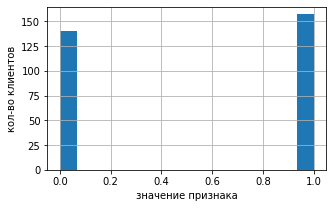

NEAR_LOCATION


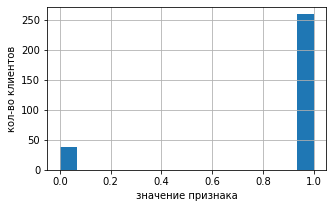

PARTNER


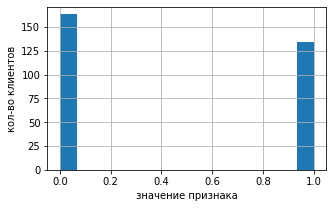

PROMO_FRIENDS


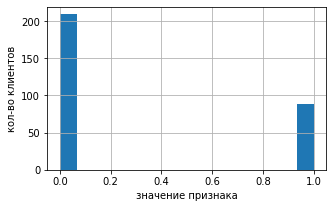

PHONE


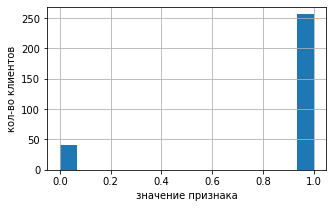

CONTRACT_PERIOD


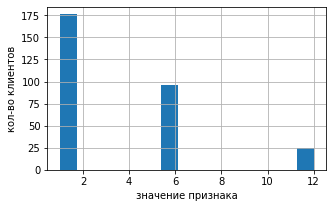

GROUP_VISITS


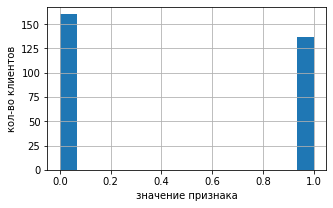

AGE


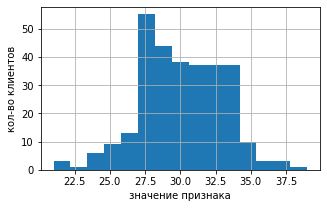

AVG_ADDITIONAL_CHARGES_TOTAL


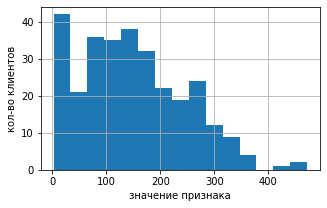

MONTH_TO_END_CONTRACT


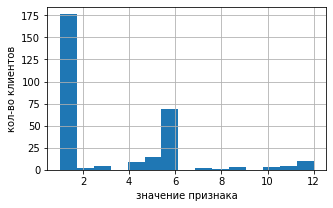

LIFETIME


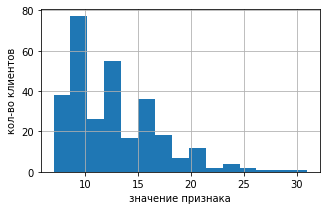

AVG_CLASS_FREQUENCY_TOTAL


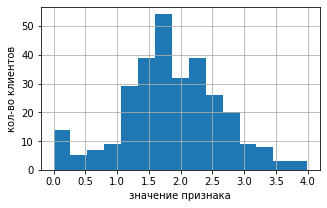

AVG_CLASS_FREQUENCY_CURRENT_MONTH


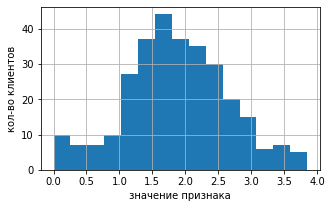

CHURN


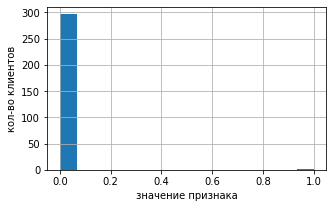

CLUSTER_KM


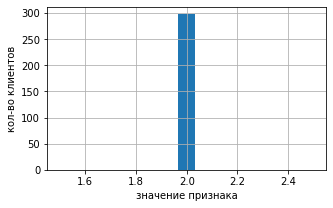

,cluster_km,Churn,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
4,2,0,0.527027,0.871622,0.452703,0.297297,0.861486,3.550676,0.459459,29.976351,148.608957,3.222973,12.635135,1.856308,1.864625
5,2,1,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,33.000000,208.071672,1.000000,8.000000,1.974417,1.518766


In [22]:
# строим гистограммы распределения для кластера 2
hist_maker(df, 'cluster_km == 2')
df_grouped2_2 = df_grouped2.query('cluster_km == 2')
display(df_grouped2_2)

#### Комментарий кластер 2
- распределение по полам почти равное
- клиент в большинстве случаев живет в районе фитнес-центра
- скорее обычный клиент, чем сотрудник, но разница незначительна
- скорее приходит сам, чем по промокоду
- указывает номер телефона
- **берет абонемент чаще на 1 мес**
- может как посещать, так и не посещать групповые занятия, различия минимальны
- возраст около 27-32 года
- доп.траты у большинства клиентов до 250 у.е.
- **до окончания контракта в большинстве случаев осталось 1 мес**
- **много лояльных клиентов от 5 мес. от первого посещения**
- ходит 1-2 раза в неделю
- ходит 1-2 раза  в среднем в неделю в текущем месяце

### Кластер 3

GENDER


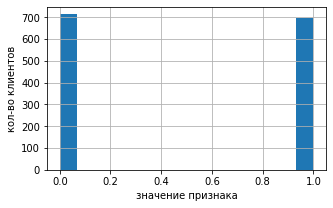

NEAR_LOCATION


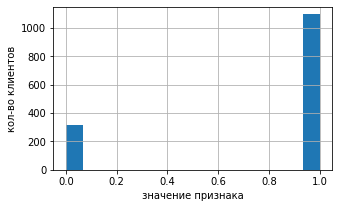

PARTNER


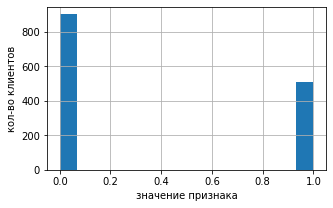

PROMO_FRIENDS


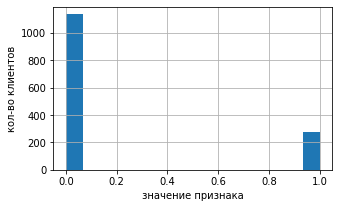

PHONE


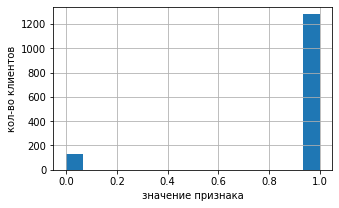

CONTRACT_PERIOD


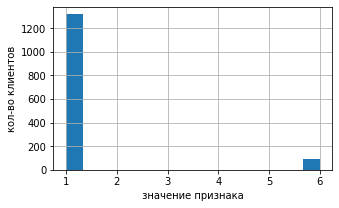

GROUP_VISITS


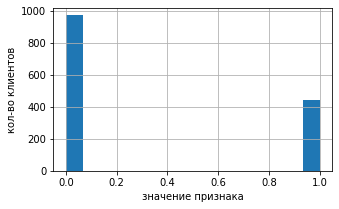

AGE


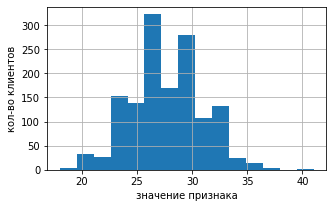

AVG_ADDITIONAL_CHARGES_TOTAL


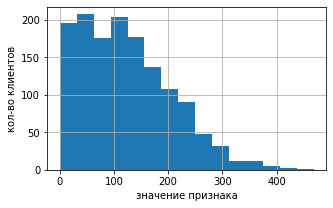

MONTH_TO_END_CONTRACT


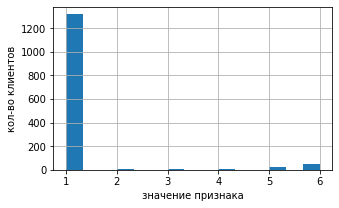

LIFETIME


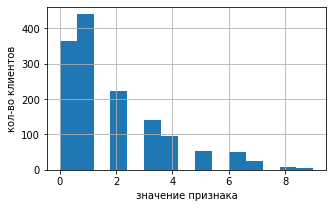

AVG_CLASS_FREQUENCY_TOTAL


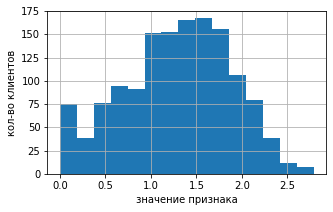

AVG_CLASS_FREQUENCY_CURRENT_MONTH


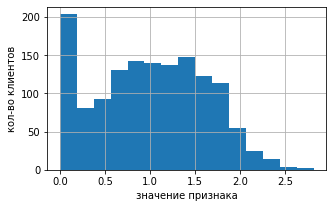

CHURN


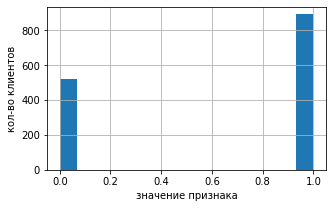

CLUSTER_KM


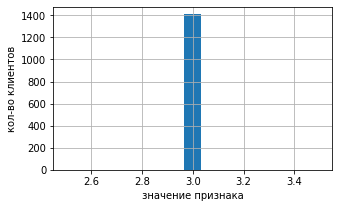

,cluster_km,Churn,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
6,3,0,0.480695,0.810811,0.401544,0.23166,0.915058,1.395753,0.401544,29.318533,145.247090,1.305019,3.270270,1.164328,1.158573
7,3,1,0.502247,0.757303,0.337079,0.17191,0.902247,1.286517,0.259551,26.800000,111.377315,1.248315,0.983146,1.355323,0.896975


In [23]:
# строим гистограммы распределения для кластера 3
hist_maker(df, 'cluster_km == 3')
df_grouped2_3 = df_grouped2.query('cluster_km == 3')
display(df_grouped2_3)

#### Комментарий кластер 3
- распределение по полам почти равное
- клиент в большинстве случаев живет в районе фитнес-центра
- **скорее сотрудник компании-партнера, чем обычный клиент**
- в большинстве случаев приходит без использования промо-кода друзей
- указывает номер телефона
- **в большинстве случаев берет абонемент на 1 мес.**
- **скорее не посещает групповые занятия**
- возраст 25 - 30 лет
- доп.траты у большинства клиентов до 150 у.е.
- **до окончания контракта в большинстве случаев осталось 1 мес**
- **новые пользователи - до 3 мес с даты первого посещения**
- ходит в зал до 2 раз в неделю
- **в текущем месяце кол-во посещений снижается, растет кол-во непосещающих пользователей**

### Кластер 4

GENDER


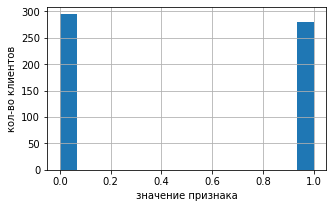

NEAR_LOCATION


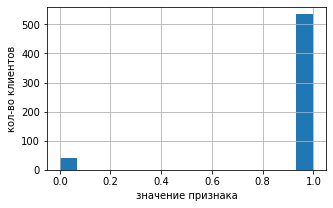

PARTNER


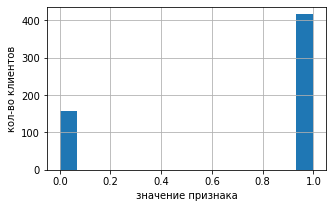

PROMO_FRIENDS


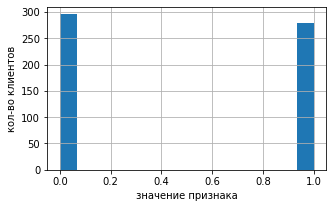

PHONE


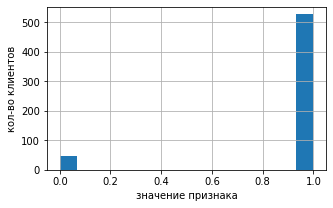

CONTRACT_PERIOD


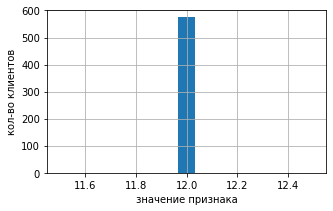

GROUP_VISITS


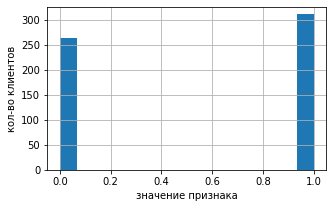

AGE


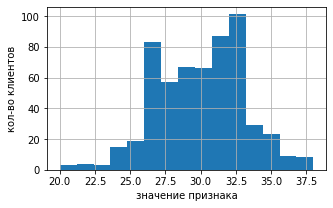

AVG_ADDITIONAL_CHARGES_TOTAL


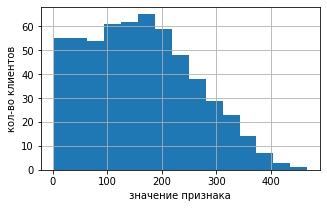

MONTH_TO_END_CONTRACT


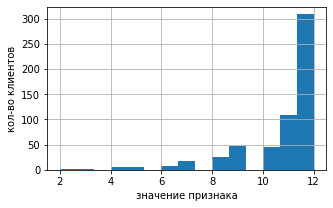

LIFETIME


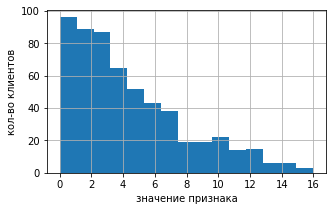

AVG_CLASS_FREQUENCY_TOTAL


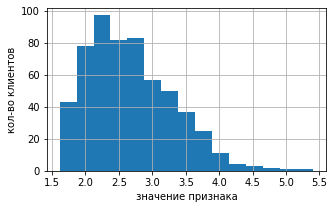

AVG_CLASS_FREQUENCY_CURRENT_MONTH


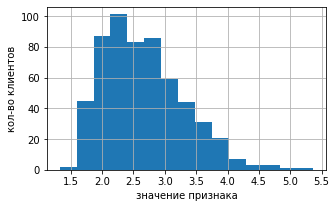

CHURN


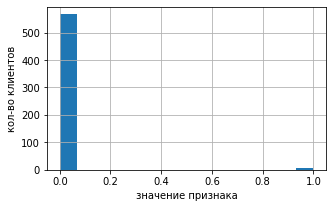

CLUSTER_KM


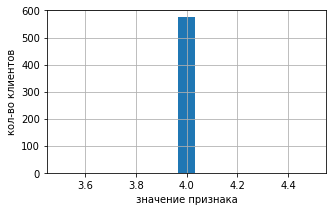

,cluster_km,Churn,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
8,4,0,0.485866,0.932862,0.724382,0.489399,0.916961,12.0,0.545936,29.952297,163.148591,10.80742,4.664311,2.675451,2.674803
9,4,1,0.625000,0.750000,0.750000,0.250000,0.875000,12.0,0.250000,25.750000,99.115188,10.62500,1.125000,2.402377,1.858820


In [24]:
# строим гистограммы распределения для кластера 3
hist_maker(df, 'cluster_km == 4')
df_grouped2_3 = df_grouped2.query('cluster_km == 4')
display(df_grouped2_3)

#### Комментарий кластер 4
- распределение по полам почти равное
- клиент в большинстве случаев живет в районе фитнес-центра
- **скорее сотрудник, чем обычный клиент**
- может прийти как по промокоду, так и без, различия минимальные
- указывает номер телефона
- **берет абонемент на 12 мес.**
- может как посещать, так и не посещать групповые занятия, различия минимальные
- возраст около 30 лет
- доп.траты у большинства клиентов до 250 у.е.
- **до окончания контракта в большинстве случаев осталось 10-12 мес**
- может быть как новым, так и старым клиентом, но большинство в диапазоне от 0 до 6 мес. от первого посещения
- **ходит в зал 2-3 раза в неделю- регулярно** 
- **в текущем месяце ходит даже чаще**

### Отток по кластерам

In [25]:
# высчитываем размеры кластеров и доли 
df_size = df.groupby(['cluster_km', 'Churn']).agg({'gender': 'count'})
df_size = df_size.reset_index()
# превращаем таблицу в строко-ориентированную
df_size = df_size.pivot_table(index = 'cluster_km', columns = 'Churn', values = 'gender', aggfunc = 'sum')
df_size = df_size.reset_index()
df_size.columns = ['cluster_km', 0, 1]

# высчитываем долю оттока кластера
df_size['churn_rate'] = df_size[1] / (df_size[0] + df_size[1])
display(df_size.sort_values(by = 'churn_rate', ascending = False))

,cluster_km,0,1,churn_rate
3,3,518,890,0.632102
1,1,953,113,0.106004
0,0,606,49,0.074809
4,4,566,8,0.013937
2,2,296,1,0.003367


#### Комментарий
- Лидер по оттоку кластер - 3(63% клиентов)
- Кластер с минимальным оттоком - 2(всего 1 клиент ушел) и 4(1% отток клиентов)

### Вывод
На основе кластеризации и анализа признаков можно заключить.

В целом для **выбыших** почти во всех кластерах преобладают следующие закономерности:
- больше тех, кто живет не в районе центра
- преобладают те, кто пришел сам, а не по промокоду
- длительность абонемента у выбывших ниже
- больше тех, кто не посещал групповые занятия
- чуть моложе, чем оставшиеся
- тратят на доп.услуги меньше, чем оставшиеся
- падает частота посещений в неделю в текущем месяце

**У наиболее выдающихся кластеров наблюдаются следующие особенности**

- **Среди кластера 3 - лидера по оттоку:**
    - больше сотрудников компаний-партнеров, 
    - абонементы куплены на минимальный срок (1 мес), 
    - групповые занятия скорее не посещаются, 
    - абонемент в большинстве случаев закончится в течение 1 мес, 
    - большинство пользователей новые и есть снижение кол-ва средних посещений в неделю в текущем месяце
- **Среди кластеров 2 и 4 - лидеров по лояльным клиентам:**
    - большое кол-во лояльных пользователей с длительным lifetime от 5 мес - кластер 2
    - скорее обычный клиент, чем сотрудник - кластер 4
    - берет абонемент на 12 мес - кластер 4
    - до окончания контракта в большинстве случаев осталось 12 мес - кластер 4
    - в текущем месяце ходит даже чаще - кластер 4

## Общий вывод и рекомендации

### Резюме по подготовке данных

В ходе подготовки данных:
- пропусков обнаружено не было
- полных дубликатов обнаружено не было

### Резюме по модели

Проведено сравнение двух моделей бинарной классификации: логистической регрессии и случайного леса

По результатам сравнения метрик лучшей оказалась логистическая регрессия:
- accuracy:0.90 precision:0.79 recall:0.79 - логистическая регрессия
- accuracy:0.86 precision:0.69 recall:0.77 - случайный лес

### Выводы по кластеризации

По результатам анализа выбывших клиентов и кластера, где такие клиенты доминируют можно сделать следующий **портрет выбывшего клиента:**
- живет не в районе центра
- пришел сам, не по промокоду друзей
- купил месячный абонемент
- групповые занятия не посещает
- доп.услугами пользуется мало
- до конца абонемента остается месяц
- в текущем месяце ходить стал реже

### Рекомендации

Для удержания выбывших клиентов рекомендуется:
- таргетировать рекламу преимущественно на жителей района, где центр расположен
- давать доп.бонусы за привлечение друзей
- промотировать полугодовые и годовые абонементы в момент продажи (за счет большей выгоды по сравнению с месячными и скидок на доп.услуги)
- рекламировать групповые занятия, информировать непосещающих клиентов о групповых занятиях
- промотировать доп.услуги новым клиентам (бесплатное пробное посещение каждой услуги, например)
- напоминать клиентам о скором окончании абонемента и предлагать выгодные условия пролонгации
- напоминать клиентам, у которых сократилось кол-во посещений в текущем месяце о новых программах, доп.услугах